# Fit the RLDDM on individual data

In [1]:
import rlssm
import pandas as pd
import os

## Import the data

In [2]:
# import some example data:
data = rlssm.load_example_dataset(hierarchical_levels = 1)

data.head()

participant  block_label  trial_block  f_cor  f_inc  cor_option  \
0           10            1            1     61     52           4   
1           10            1            2     54     37           4   
2           10            1            3     51     51           4   
3           10            1            4     50     35           3   
4           10            1            5     59     50           4   

   inc_option  times_seen        rt  accuracy  
0           3           1  1.285418         0  
1           2           1  1.577622         0  
2           3           2  1.564731         0  
3           1           2  1.217245         1  
4           2           3  1.929781         0

## Initialize the model

In [3]:
# you can "turn on and off" different mechanisms:
model = rlssm.RLDDModel(hierarchical_levels=1,
                        separate_learning_rates=False,
                        threshold_modulation=False,
                        nonlinear_mapping=True)

Using cached StanModel


## Fit

In [4]:
# sampling parameters
n_iter = 3000
n_warmup = 1000
n_chains = 2

# learning parameters
K = 4 # n options in a learning block (participants see 2 at a time)
initial_value_learning = 27.5 # intitial learning value (Q0)

In [5]:
model_fit = model.fit(
    data,
    K,
    initial_value_learning,
    warmup = n_warmup,
    iter = n_iter,
    chains = n_chains)

Fitting the model using the priors:
alpha_priors {'mu': 0, 'sd': 1}
drift_scaling_priors {'mu': 1, 'sd': 50}
drift_asymptote_priors {'mu': 1, 'sd': 50}
threshold_priors {'mu': 1, 'sd': 5}
ndt_priors {'mu': 1, 'sd': 1}


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Checks MCMC diagnostics:
n_eff / iter looks reasonable for all parameters
6.0 of 4000 iterations ended with a divergence (0.15%)
  Try running with larger adapt_delta to remove the divergences
6 of 4000 iterations saturated the maximum tree depth of 10 (0.15%)
Run again with max_depth set to a larger value to avoid saturation
E-BFMI indicated no pathological behavior


### get Rhat

In [6]:
model_fit.rhat

rhat         variable
0  1.018417            alpha
1  1.037281    drift_scaling
2  1.027634  drift_asymptote
3  1.000449        threshold
4  1.001236              ndt

### get wAIC

In [7]:
model_fit.waic

{'lppd': -222.10485280567747,
 'p_waic': 4.70099816274729,
 'waic': 453.6117019368495,
 'waic_se': 28.500117385818506}

## Posteriors

In [8]:
model_fit.samples.describe()

chain         draw  transf_alpha  transf_drift_scaling  \
count  4000.000000  4000.000000   4000.000000           4000.000000   
mean      0.500000   999.500000      0.037983              0.794183   
std       0.500063   577.422379      0.039915              4.429973   
min       0.000000     0.000000      0.000057              0.002300   
25%       0.000000   499.750000      0.014890              0.013506   
50%       0.500000   999.500000      0.027752              0.029816   
75%       1.000000  1499.250000      0.048028              0.103515   
max       1.000000  1999.000000      0.587557             64.531895   

       transf_drift_asymptote  transf_threshold   transf_ndt  
count             4000.000000       4000.000000  4000.000000  
mean                36.160095          1.873717     0.797365  
std                 30.778307          0.063024     0.010966  
min                  2.043295          1.685766     0.739923  
25%                  9.554932          1.828763     0.790487  
50%                 28.618335          1.873455     0.798071  
75%                 54.034849          1.915392     0.805142  
max                190.530448          2.084672     0.826664

In [9]:
import seaborn as sns
sns.set(context = "talk", 
        style = "white", 
        palette = "husl",
        rc={'figure.figsize':(15, 8)})

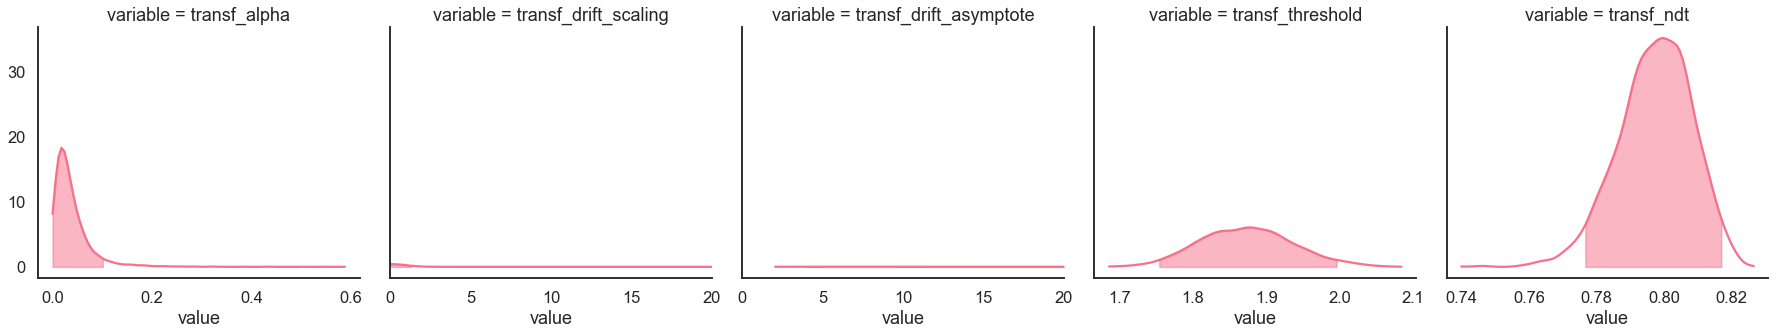

In [10]:
g = model_fit.plot_posteriors(height=5, show_intervals='HDI');

g.axes.flat[1].set_xlim(0, 20)
g.axes.flat[2].set_xlim(0, 20);

## Posterior predictives

### Ungrouped

In [11]:
pp = model_fit.get_posterior_predictives_df(n_posterior_predictives=100)
pp

variable        rt                                                    \
trial          1         2         3         4         5         6     
sample                                                                 
1         1.262933  1.069933  1.784933  1.543933  1.083933  1.111933   
2         1.025510  5.076510  1.705510  1.124510  1.230510  1.659510   
3         1.563506  1.586506  1.463506  1.030506  0.960506  1.705506   
4         1.377698  1.081698  2.731698  2.004698  1.227698  1.097698   
5         1.211327  0.994327  1.420327  1.985327  0.982327  1.153327   
...            ...       ...       ...       ...       ...       ...   
96        1.638157  0.958157  1.110157  1.300157  1.791157  1.347157   
97        1.278817  1.766817  1.079817  1.173817  1.616817  2.170817   
98        1.075953  1.300953  1.090953  1.380953  1.067953  2.644953   
99        1.154160  1.308160  1.598160  3.026160  2.950160  0.944160   
100       2.028603  1.326603  1.547603  1.012603  1.077603  3.032603   

variable                                          ... accuracy                 \
trial          7         8         9         10   ...      230  231  232  233   
sample                                            ...                           
1         2.414933  1.016933  1.438933  1.144933  ...      1.0  0.0  1.0  1.0   
2         1.058510  2.201510  1.932510  1.383510  ...      1.0  1.0  1.0  1.0   
3         1.394506  1.566506  1.668506  1.237506  ...      1.0  1.0  0.0  1.0   
4         2.421698  2.383698  1.264698  2.216698  ...      1.0  1.0  1.0  1.0   
5         1.323327  1.587327  1.402327  1.462327  ...      1.0  1.0  1.0  1.0   
...            ...       ...       ...       ...  ...      ...  ...  ...  ...   
96        1.563157  1.162157  1.243157  2.055157  ...      1.0  1.0  1.0  1.0   
97        1.960817  1.078817  1.794817  1.288817  ...      1.0  1.0  1.0  1.0   
98        1.694953  1.517953  1.402953  1.505953  ...      1.0  1.0  1.0  1.0   
99        1.161160  1.392160  1.694160  1.407160  ...      1.0  1.0  1.0  1.0   
100       1.243603  1.232603  1.043603  0.913603  ...      1.0  1.0  1.0  1.0   

variable                                
trial     234  235  236  237  238  239  
sample                                  
1         1.0  1.0  1.0  1.0  1.0  0.0  
2         1.0  0.0  1.0  1.0  1.0  0.0  
3         1.0  1.0  1.0  1.0  0.0  1.0  
4         1.0  1.0  1.0  1.0  1.0  1.0  
5         1.0  1.0  1.0  1.0  1.0  1.0  
...       ...  ...  ...  ...  ...  ...  
96        1.0  0.0  1.0  1.0  1.0  1.0  
97        1.0  1.0  1.0  1.0  1.0  1.0  
98        1.0  1.0  1.0  1.0  1.0  1.0  
99        1.0  0.0  1.0  1.0  1.0  1.0  
100       1.0  0.0  1.0  1.0  1.0  0.0  

[100 rows x 478 columns]

In [12]:
pp_summary = model_fit.get_posterior_predictives_summary(n_posterior_predictives=100)
pp_summary

mean_accuracy   mean_rt  skewness  quant_10_rt_low  quant_30_rt_low  \
sample                                                                        
1            0.736402  1.597975  2.020770         1.046733         1.180133   
2            0.803347  1.568459  2.537627         1.036110         1.224110   
3            0.744770  1.592808  2.887339         1.006506         1.161506   
4            0.748954  1.596832  1.956484         1.062198         1.234398   
5            0.765690  1.517963  2.230927         1.002327         1.154827   
...               ...       ...       ...              ...              ...   
96           0.686192  1.420931  1.572826         0.967357         1.108957   
97           0.778243  1.513348  3.399520         1.023017         1.141617   
98           0.757322  1.657665  2.967858         1.047453         1.262653   
99           0.761506  1.491198  2.239910         1.002160         1.203360   
100          0.769874  1.476908  2.132750         1.057803         1.188803   

        quant_50_rt_low  quant_70_rt_low  quant_90_rt_low  quant_10_rt_up  \
sample                                                                      
1              1.408933         1.834733         2.707733        1.018933   
2              1.456510         1.908310         2.555710        1.007610   
3              1.417506         1.887506         2.220506        1.027106   
4              1.577698         1.925998         2.465298        1.015098   
5              1.437327         1.729827         2.573327        1.000527   
...                 ...              ...              ...             ...   
96             1.323157         1.570757         2.142957        0.958757   
97             1.316817         1.542817         1.993417        1.025817   
98             1.514953         1.938653         2.723953        1.015953   
99             1.428160         1.722160         2.474160        1.015160   
100            1.390603         1.567003         2.074803        0.990203   

        quant_30_rt_up  quant_50_rt_up  quant_70_rt_up  quant_90_rt_up  
sample                                                                  
1             1.226433        1.405433        1.629933        2.320933  
2             1.186710        1.328510        1.644910        2.335410  
3             1.195906        1.334506        1.637906        2.401806  
4             1.157698        1.359698        1.651698        2.269698  
5             1.139527        1.300327        1.564927        2.151527  
...                ...             ...             ...             ...  
96            1.081057        1.277157        1.438257        2.128157  
97            1.198817        1.376317        1.621317        2.195317  
98            1.177953        1.370953        1.686953        2.368953  
99            1.135160        1.244660        1.503260        2.128160  
100           1.108203        1.276603        1.540803        2.212203  

[100 rows x 13 columns]

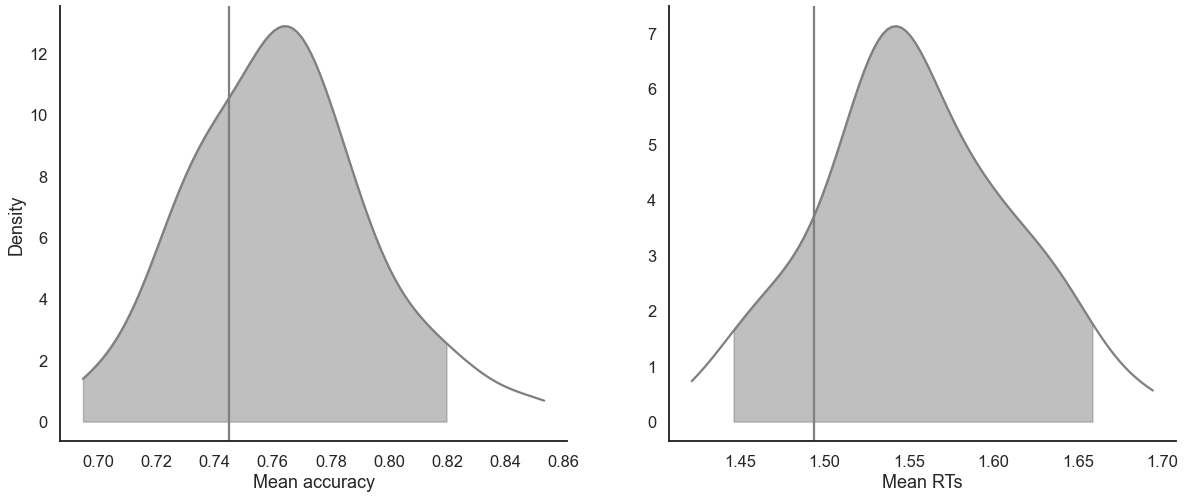

In [13]:
model_fit.plot_mean_posterior_predictives(n_posterior_predictives=100, figsize=(20,8), show_intervals='HDI');

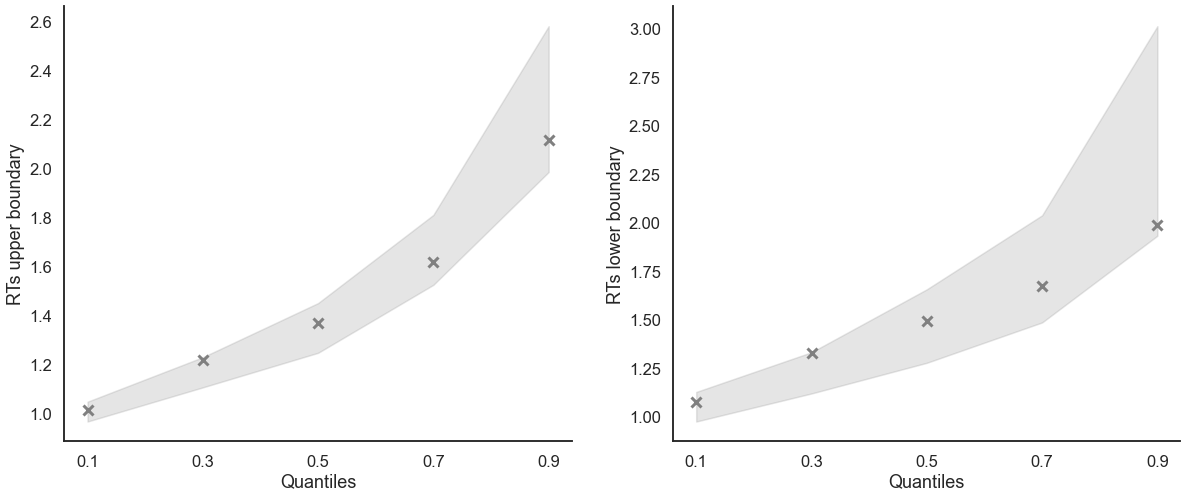

In [14]:
model_fit.plot_quantiles_posterior_predictives(n_posterior_predictives=100, kind='shades');

### Grouped

In [15]:
import numpy as np

In [16]:
# Define new grouping variables, in this case, for the different choice pairs, but any grouping var can do
data['choice_pair'] = 'AB'
data.loc[(data.cor_option == 3) & (data.inc_option == 1), 'choice_pair'] = 'AC'
data.loc[(data.cor_option == 4) & (data.inc_option == 2), 'choice_pair'] = 'BD'
data.loc[(data.cor_option == 4) & (data.inc_option == 3), 'choice_pair'] = 'CD'

data['block_bins'] = pd.cut(data.trial_block, 8, labels=np.arange(1, 9))

In [17]:
model_fit.get_grouped_posterior_predictives_summary(
                grouping_vars=['block_label', 'choice_pair'],
                quantiles=[.3, .5, .7],
                n_posterior_predictives=100)

mean_accuracy   mean_rt  skewness  \
block_label choice_pair sample                                      
1           AB          1                0.75  2.049033  1.861715   
                        2                0.65  1.672710  1.528835   
                        3                0.55  1.501656  0.745925   
                        4                0.75  1.343298  1.370879   
                        5                0.65  1.492577  2.332409   
...                                       ...       ...       ...   
3           CD          96               0.55  1.266957  1.404526   
                        97               0.60  1.652267  0.660315   
                        98               0.55  1.756253  0.798266   
                        99               0.70  1.721210  3.783809   
                        100              0.70  1.791353  2.759446   

                                quant_30_rt_low  quant_30_rt_up  \
block_label choice_pair sample                                    
1           AB          1              1.215533        1.493133   
                        2              1.153710        1.194110   
                        3              1.239906        1.102506   
                        4              1.110298        1.043498   
                        5              1.176527        1.166127   
...                                         ...             ...   
3           CD          96             1.086357        1.191157   
                        97             1.150917        1.331017   
                        98             1.631753        1.265953   
                        99             1.402160        1.234060   
                        100            0.991603        1.474003   

                                quant_50_rt_low  quant_50_rt_up  \
block_label choice_pair sample                                    
1           AB          1              1.261933        1.537933   
                        2              1.548510        1.394510   
                        3              1.471506        1.159506   
                        4              1.464698        1.161698   
                        5              1.297327        1.237327   
...                                         ...             ...   
3           CD          96             1.123157        1.262157   
                        97             1.527317        1.603817   
                        98             1.652953        1.288953   
                        99             1.556660        1.314660   
                        100            1.134103        1.665103   

                                quant_70_rt_low  quant_70_rt_up  
block_label choice_pair sample                                   
1           AB          1              1.385933        2.341733  
                        2              1.751310        1.922710  
                        3              1.657906        1.648506  
                        4              1.526298        1.313698  
                        5              1.693927        1.416327  
...                                         ...             ...  
3           CD          96             1.181957        1.365157  
                        97             2.327617        1.847717  
                        98             2.349353        1.884953  
                        99             1.684660        1.701360  
                        100            1.659103        1.834503  

[1200 rows x 9 columns]

In [18]:
model_fit.get_grouped_posterior_predictives_summary(
                grouping_vars=['block_bins'],
                quantiles=[.3, .5, .7],
                n_posterior_predictives=100)

mean_accuracy   mean_rt  skewness  quant_30_rt_low  \
block_bins sample                                                       
1          1            0.700000  1.602333  1.979790         1.158733   
           2            0.566667  1.757410  1.151978         1.383910   
           3            0.466667  1.813140  1.656559         1.101506   
           4            0.566667  1.899765  0.471722         1.463898   
           5            0.433333  1.572861  1.098442         1.180327   
...                          ...       ...       ...              ...   
8          96           0.862069  1.374777  2.498250         1.055157   
           97           0.862069  1.655334  0.906741         1.427517   
           98           0.827586  1.357953  2.034553         1.469153   
           99           0.862069  1.354539  0.819861         1.521060   
           100          0.965517  1.464017  2.051352         1.133603   

                   quant_30_rt_up  quant_50_rt_low  quant_50_rt_up  \
block_bins sample                                                    
1          1             1.141933         1.284933        1.326933   
           2             1.077710         1.912510        1.238510   
           3             1.148406         1.655006        1.530006   
           4             1.342298         1.783698        1.718698   
           5             1.087927         1.458327        1.264327   
...                           ...              ...             ...   
8          96            1.124157         1.142157        1.198157   
           97            1.215217         1.499317        1.459817   
           98            1.014053         1.689953        1.115453   
           99            1.143760         1.748660        1.229160   
           100           1.094103         1.133603        1.317603   

                   quant_70_rt_low  quant_70_rt_up  
block_bins sample                                   
1          1              1.535933        1.756933  
           2              2.361110        1.508510  
           3              1.874006        2.292106  
           4              2.064898        2.397498  
           5              1.775127        1.447327  
...                            ...             ...  
8          96             1.422057        1.367757  
           97             1.592817        1.846817  
           98             1.845153        1.261953  
           99             1.941960        1.382560  
           100            1.133603        1.514103  

[800 rows x 9 columns]

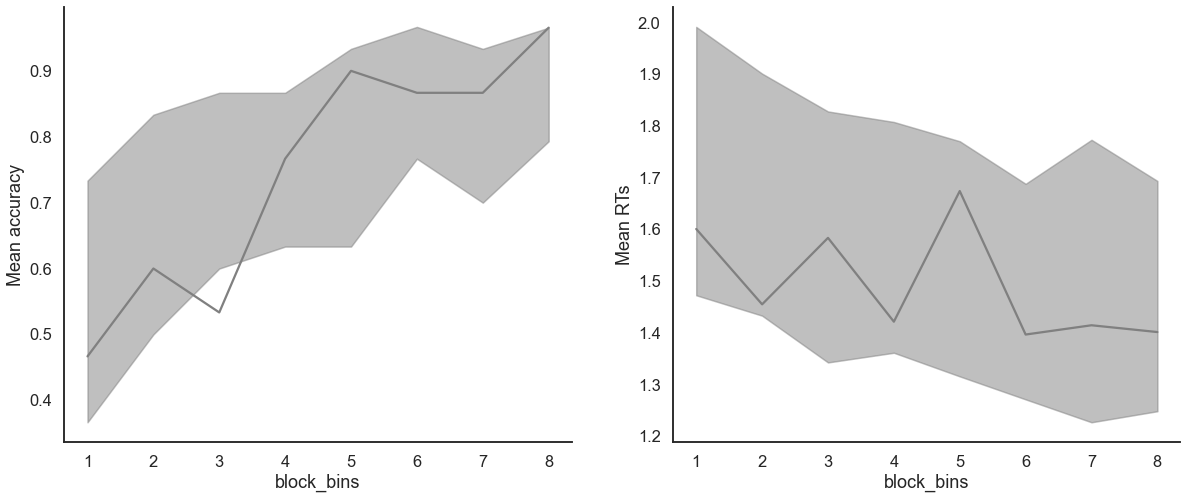

In [19]:
model_fit.plot_mean_grouped_posterior_predictives(grouping_vars=['block_bins'], 
                                                  n_posterior_predictives=100, 
                                                  figsize=(20,8));

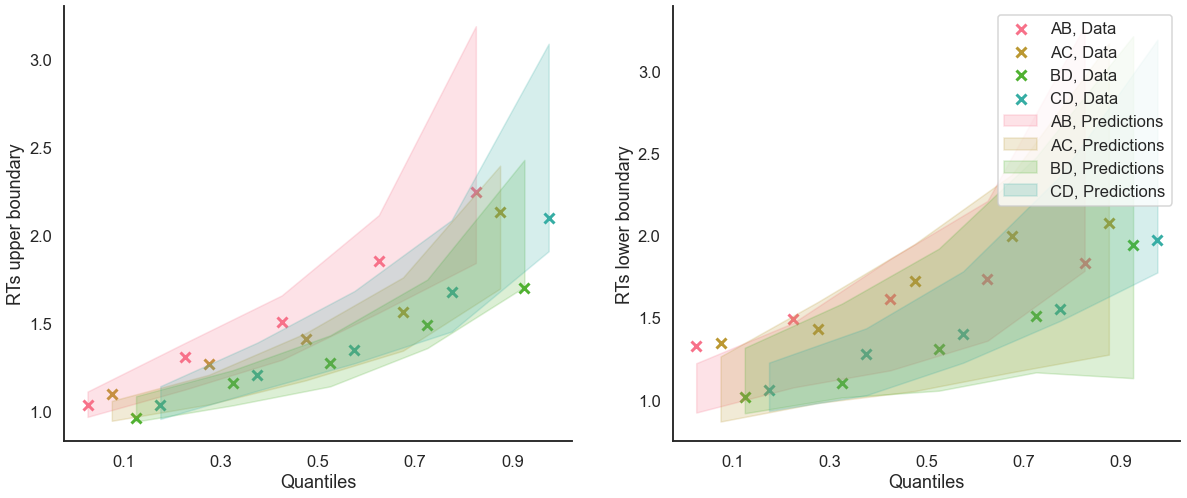

In [20]:
model_fit.plot_quantiles_grouped_posterior_predictives(n_posterior_predictives=100,
                                                        grouping_var='choice_pair',
                                                        kind='shades',
                                                        quantiles=[.1, .3, .5, .7, .9]);

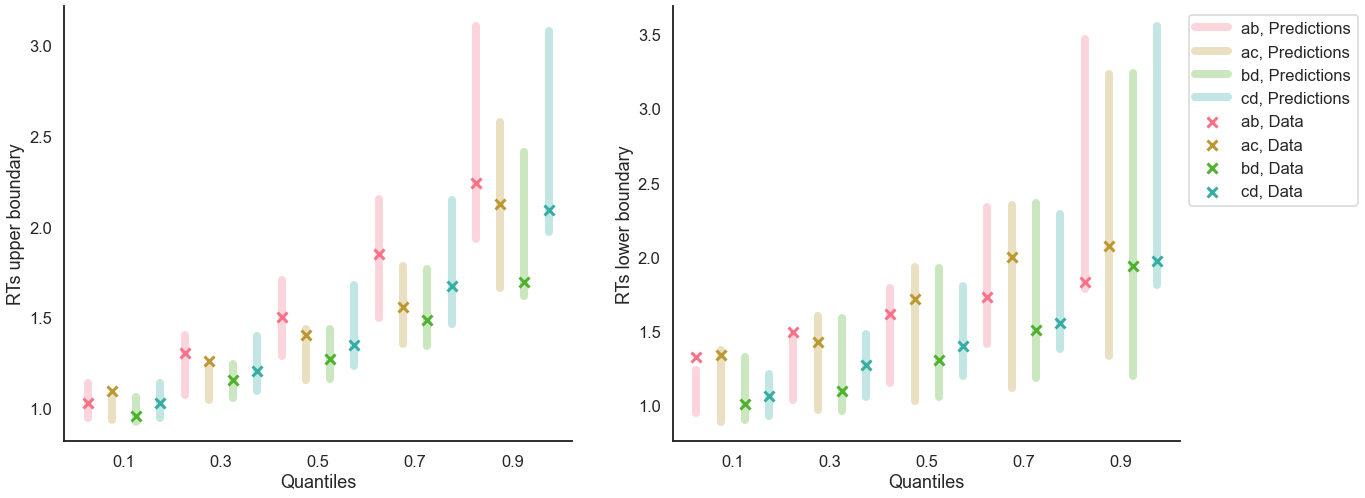

In [21]:
model_fit.plot_quantiles_grouped_posterior_predictives(
    n_posterior_predictives=300,
    grouping_var='choice_pair',
    palette = sns.color_palette('husl'),
    intervals_kws={'alpha': .3, 'lw':8},
    hue_order=['AB', 'AC', 'BD', 'CD'],
    hue_labels=['ab', 'ac', 'bd', 'cd']);